In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

[Dataset from University of Notre Dame](https://www3.nd.edu/~rwilliam/stats3/L04.pdf) for demonstration of **logistic regression.**

It is being used here to compare output from `appelpy` to output from Stata directly.

In [2]:
df = pd.read_stata('data/glm-logit.dta')

In [3]:
df.head()

,grade,gpa,tuce,psi
0,0,2.06,22,1
1,1,2.39,19,1
2,0,2.63,20,0
3,0,2.92,12,0
4,0,2.76,17,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 4 columns):
grade    32 non-null int8
gpa      32 non-null float32
tuce     32 non-null int8
psi      32 non-null int8
dtypes: float32(1), int8(3)
memory usage: 480.0 bytes


# Inspect data

Let's do some exploratory data analysis on this dataset.

In [5]:
from appelpy.eda import statistical_moments

In [6]:
%%time
statistical_moments(df)

Wall time: 26.9 ms


,mean,var,skew,kurtosis
grade,0.34375,0.225586,0.657952,-1.5671
gpa,3.11719,0.211014,0.122658,-0.429932
tuce,21.9375,14.7461,-0.52511,0.0483051
psi,0.4375,0.246094,0.251976,-1.93651


In [7]:
df.nunique()

grade     2
gpa      29
tuce     14
psi       2
dtype: int64

`grade` is a binary outcome that we would like to predict in this dataset, so logistic regression is a natural choice for modelling it.

# Logistic regression

Let's do a regression of `grade` on `gpa`, `tuce`, `psi`.

In [8]:
from appelpy.discrete_model import Logit

In [9]:
y_list = ['grade']
X_list = ['gpa', 'tuce', 'psi']

In [10]:
%%time
model1 = Logit(df, y_list, X_list)

C:\ProgramData\Miniconda3\envs\appelpy-dev\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Model fitting in progress...
Model fitted.
Wall time: 258 ms


## Standardized and unstandardized estimates

The **unstandardized estimates** can be returned in two formats: the **coefficients** themselves and their **odds ratio** equivalents.

In [11]:
model1.results_output

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  grade   No. Observations:                   32
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            3
Date:                Tue, 27 Aug 2019   Pseudo R-squ.:                  0.3740
Time:                        18:34:46   Log-Likelihood:                -12.890
converged:                       True   LL-Null:                       -20.592
                                        LLR p-value:                  0.001502
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.0213      4.931     -2.641      0.008     -22.687      -3.356
gpa            2.8261      1.263      2.238      0.025       0.351       5.301
tuce           0.0952      0.142      0.672      0.501      -0.182       0.373
psi            2.3787      1.065      2.234      0.025       0.292       4.465
==============================================================================
"""

There are two significant regressors in the model.

In [12]:
model1.significant_regressors(0.05)

['gpa', 'psi']

In [13]:
model1.odds_ratios

gpa     16.879721
tuce     1.099832
psi     10.790733
Name: odds_ratios, dtype: float64

The `results_output_standardized` object contains the **standardized estimates** of the regressors (and the unstandardized ones).

Standardized coefficients are sometimes called **beta coefficients**.

The output is similar to what would be returned by Stata's _`listcoef` command_.

These are the standardized estimates listed:
- `coef_stdX`: x-standardized coefficient, i.e. how much does `y` increase with a one-standard deviation increase in `x`.
- `coef_stdXy`: fully standardized coefficient, i.e. by how many standard deviations does `y` increase with a one=standard deviation increase in `x`.
- `stdev_X`: standard deviation of regressor

In [14]:
model1.results_output_standardized

,coef,z,P>|z|,coef_stdX,coef_stdXy,stdev_X
grade,,,,,,
gpa,+2.8261,+2.238,0.025,+1.3190,+0.4912,0.4667
tuce,+0.0952,+0.672,0.501,+0.3713,+0.1383,3.9015
psi,+2.3787,+2.234,0.025,+1.1989,+0.4465,0.5040


Compare the results from the Stata command  `listcoef, std help` below:

```
logit (N=32): Unstandardized and standardized estimates

 Observed SD: 0.4826
 Latent SD: 2.6851

--------------------------------------------------------------------------------
             |     b           z      P>|z|    bStdX    bStdY    bStdXY   SDofX
-------------+------------------------------------------------------------------
 gpa         |   2.8261      2.238    0.025    1.319    1.053    0.491    0.467
 tuce        |   0.0952      0.672    0.501    0.371    0.035    0.138    3.902
 1.psi       |   2.3787      2.234    0.025    1.199    0.886    0.447    0.504
 constant    | -13.0213     -2.641    0.008        .        .        .        .
--------------------------------------------------------------------------------
 b = raw coefficient
 z = z-score for test of b=0
 P>|z| = p-value for z-test
 bStdX = x-standardized coefficient
 bStdY = y-standardized coefficient
 bStdXY = fully standardized coefficient
 SDofX = standard deviation of X
 ```

## Model selection

Some model selection statistics are stored in the `model_selection_stats` attribute.

In [15]:
model1.model_selection_stats

{'Log-likelihood': -12.88963346533348,
 'Pseudo R-squared': 0.3740383321251376,
 'AIC': 33.779266930666964,
 'BIC': 39.642210541865865}

The log-likelihood is also stored in its own attribute `log_likelihood` for ease of reference.

In [16]:
model1.log_likelihood

-12.88963346533348

## Prediction

The `predict` method can be used to return estimated probabilities for observations.

In [17]:
%%time
preds = model1.predict(df[X_list])
preds

Wall time: 0 ns


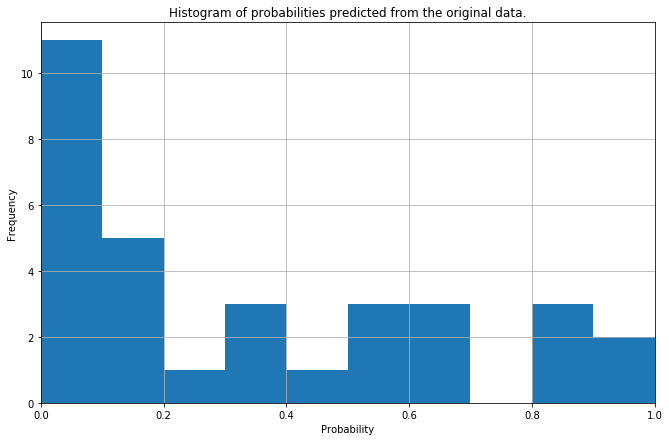

In [18]:
fig, ax = plt.subplots(figsize=(11,7))
pd.Series(preds).hist(ax=ax, range=(0,1))
ax.set_xlim([0, 1])
ax.set_title('Histogram of probabilities predicted from the original data.')
ax.set_ylabel('Frequency')
ax.set_xlabel('Probability')
plt.show()